In [1]:
%matplotlib inline 

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import model
import model_utils
import preprocessing_utils

In [2]:
torch.manual_seed(1234)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 500
batch_size = 16
lr = 0.0005920310461116504
patience = 10

num_timesteps_input = 8 # 40 minutes
num_timesteps_output = 4 # 20 minutes

In [4]:
raw_trunc_dir = "./data/raw/trunc/"
process_dir = "./data/processed/"

preprocessing_utils.processed(raw_trunc_dir, process_dir, overwrite=False)
A, X, metadata, cat2index, timestamps, means, stds = preprocessing_utils.load(process_dir)

split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.8)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

training_input, training_target = preprocessing_utils.generate_dataset(train_original_data,
                                                   num_timesteps_input=num_timesteps_input,
                                                   num_timesteps_output=num_timesteps_output)
val_input, val_target = preprocessing_utils.generate_dataset(val_original_data,
                                         num_timesteps_input=num_timesteps_input,
                                         num_timesteps_output=num_timesteps_output)
test_input, test_target = preprocessing_utils.generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)

# input shape (num_samples ,num_vertices, num_timesteps_window, num_features)
# output shape (num_samples ,num_vertices, num_timesteps_window)
adj_mat = preprocessing_utils.get_normalized_adj(A)
adj_mat = torch.from_numpy(adj_mat).float()

In [5]:
stgcn = model.Stgcn_Model(nodes_num = adj_mat.shape[0], features_num = training_input.shape[3],
                    input_timesteps = num_timesteps_input, num_output = num_timesteps_output)

optimizer = torch.optim.Adam(stgcn.parameters(), lr = lr)
loss_criterion = nn.MSELoss()

In [6]:
stgcn.to(device)
adj_mat = adj_mat.to(device)
training_input = training_input.to(device)
training_target = training_target.to(device)
val_input = val_input.to(device)
val_target = val_target.to(device)

stgcn, training_loss, validation_loss = model_utils.train(stgcn, optimizer, lr, loss_criterion, epochs, patience, adj_mat,
                  training_input, training_target, val_input, val_target, batch_size)

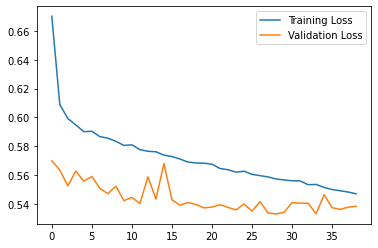

In [7]:
plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.legend()
plt.show()

In [8]:
torch.manual_seed(1234)

test_input = test_input.to(device)
test_target = test_target.to(device)

with torch.no_grad():
    test_loss = model_utils.validate(stgcn, loss_criterion, test_input, test_target, adj_mat, batch_size)
    print(test_loss)

0.47875237464904785


In [9]:
results = model_utils.predict(stgcn, test_input, adj_mat)

In [10]:
model_utils.save_model(stgcn,optimizer)

Model has been saved to path : ./saved_models/20210502/18_20_54


In [15]:
loaded_model, loaded_optimizer = model_utils.load_model(path=None)

Loading model in path : ./saved_models/20210502/18_20_54


In [16]:
torch.manual_seed(1234)

#Testing loaded model
loaded_model.to(device)

with torch.no_grad():
    test_loss = model_utils.validate(loaded_model, loss_criterion, test_input, test_target, adj_mat, batch_size)
    print(test_loss)

0.47875237464904785
